<a href="https://colab.research.google.com/github/TheRadDani/Image-Captioning/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt
nltk
numpy
opencv-python
pycocotools
scikit-image
tensorflow
matplotlib
rouge

Writing requirements.txt


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pycocotools.coco import COCO # COCO Dataset 2017
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention, Concatenate, TimeDistributed, Multiply, Lambda, RepeatVector
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.layers import add

from tensorflow.keras.models import Model, load_model


#image captioning evaluation metrics
from keras.callbacks import Callback
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
#from pyciderevalcap.ciderD.ciderD import CiderD
from nltk.translate.meteor_score import meteor_score

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
! unzip /content/annotations_trainval2017.zip

--2023-05-05 23:53:04--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.171.49, 52.216.137.172, 52.217.118.177, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.171.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  31.7MB/s    in 8.2s    

2023-05-05 23:53:13 (29.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


## Exploring COCO 2017 dataset

In [5]:
#@title API connection to the Dataset
coco=COCO("annotations/instances_train2017.json")

loading annotations into memory...
Done (t=23.37s)
creating index...
index created!


In [6]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['kitchen', 'indoor', 'accessory', 'food', 'vehicle', 'animal', 'appliance', 'outdoor', 'electronic', 'sports', 'furniture', 'person']


In [7]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

In [9]:
from collections import defaultdict

subcategories_imageIds = defaultdict(list)

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    subcategories_imageIds[subcategories[i]] = imgIds

In [10]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [11]:
train_cats = subcategories_imageIds['airplane'] 
imgIdss = coco.getImgIds(imgIds = train_cats) #identity operation where the selected categories for the training dataset with its respective id retrieve the same Ids belonging to these categories
print("Total Images: ", len(imgIdss))

Total Images:  2986


In [12]:
#@title Split dataset into training and val dataset
# shuffle the ids
np.random.shuffle(imgIdss)

# define the split ratio for train and validation datasets
split_ratio = 0.8

# calculate the number of images for training and validation datasets
num_train_images = int(len(imgIdss) * split_ratio)
num_val_images = len(imgIdss) - num_train_images

# split the image ids into training and validation datasets
train_imgIds = imgIdss[:num_train_images]
val_imgIds = imgIdss[num_train_images:]

# print the number of images in each dataset
print("Number of images in training dataset: ", len(train_imgIds))
print("Number of images in validation dataset: ", len(val_imgIds))

Number of images in training dataset:  2388
Number of images in validation dataset:  598


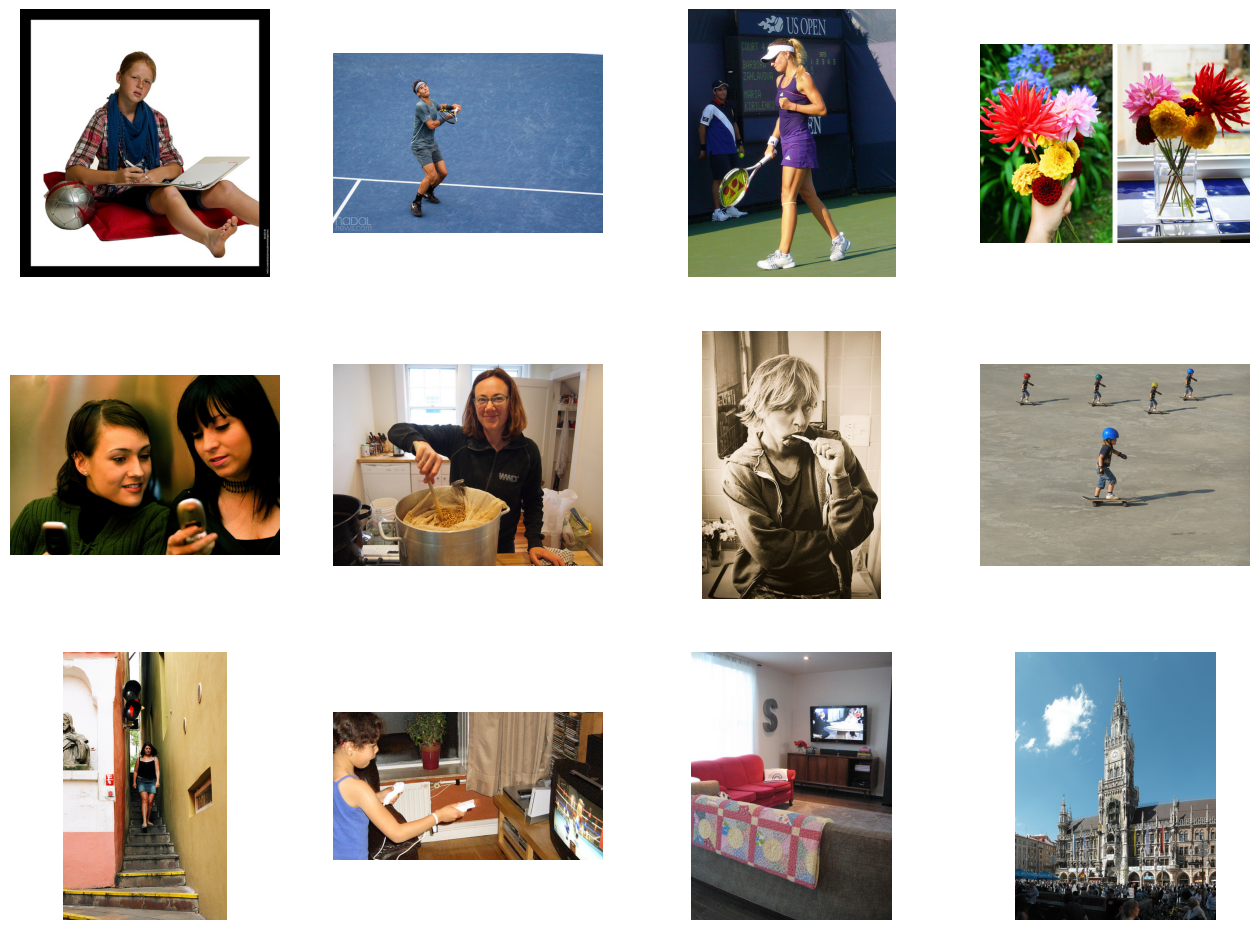

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix) #shuffle the array with Image ID randomly

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    img = coco.loadImgs(img_path)[0] #load image given ID (dictionary)
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

In [ ]:
coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

[334312,
 438121,
 541981,
 548644,
 550212,
 551412,
 552377,
 552737,
 556460,
 1227287,
 1720043,
 1751131,
 2018535,
 2152205,
 900100551241]

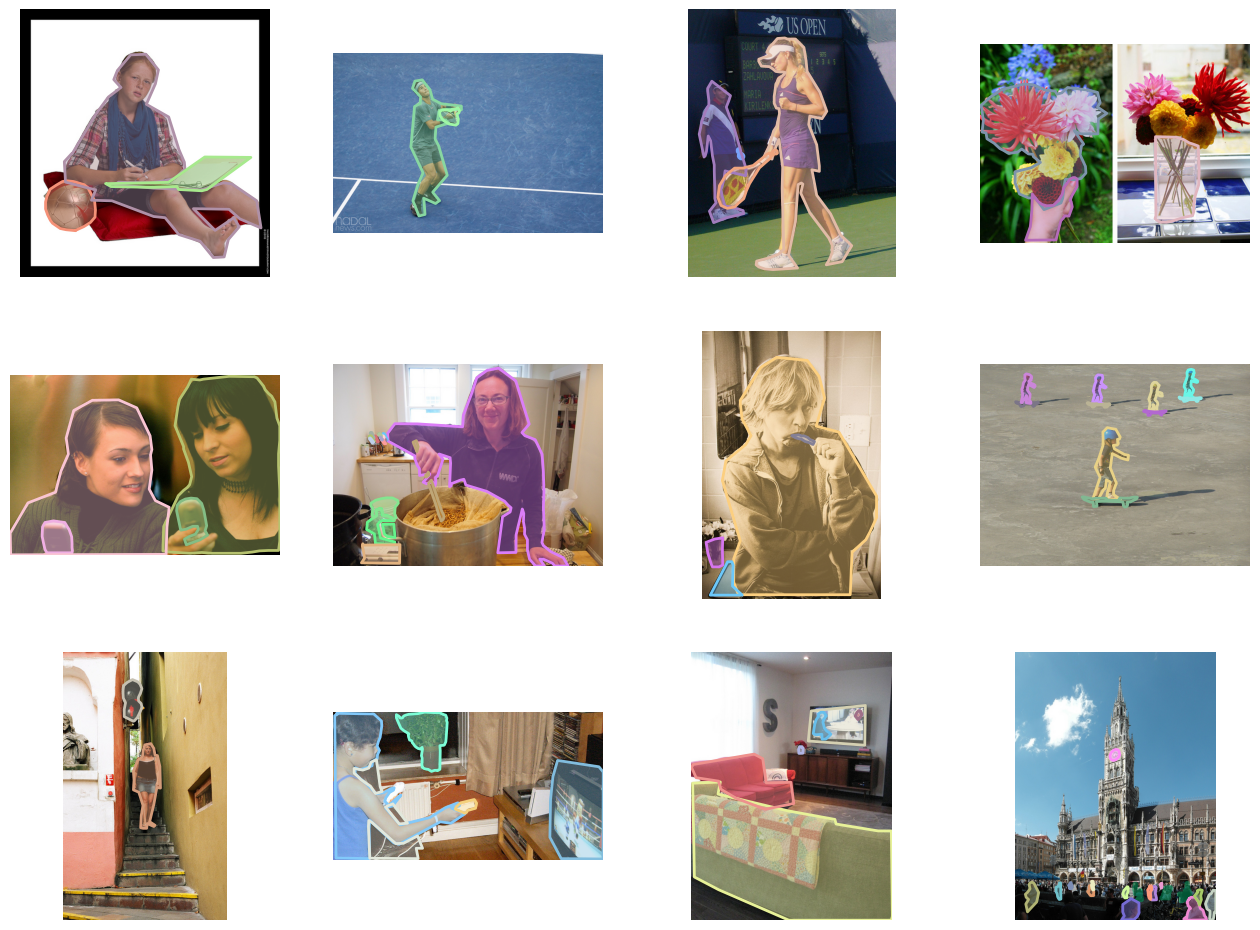

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None) #coordinates of the segmentation
    anns = coco.loadAnns(annIds) #semantic object
    coco.showAnns(anns) #overlap the segmentation object in the image
    

plt.show()

In [ ]:
#@title Images with keypoint objects
annFile = "annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=12.14s)
creating index...
index created!


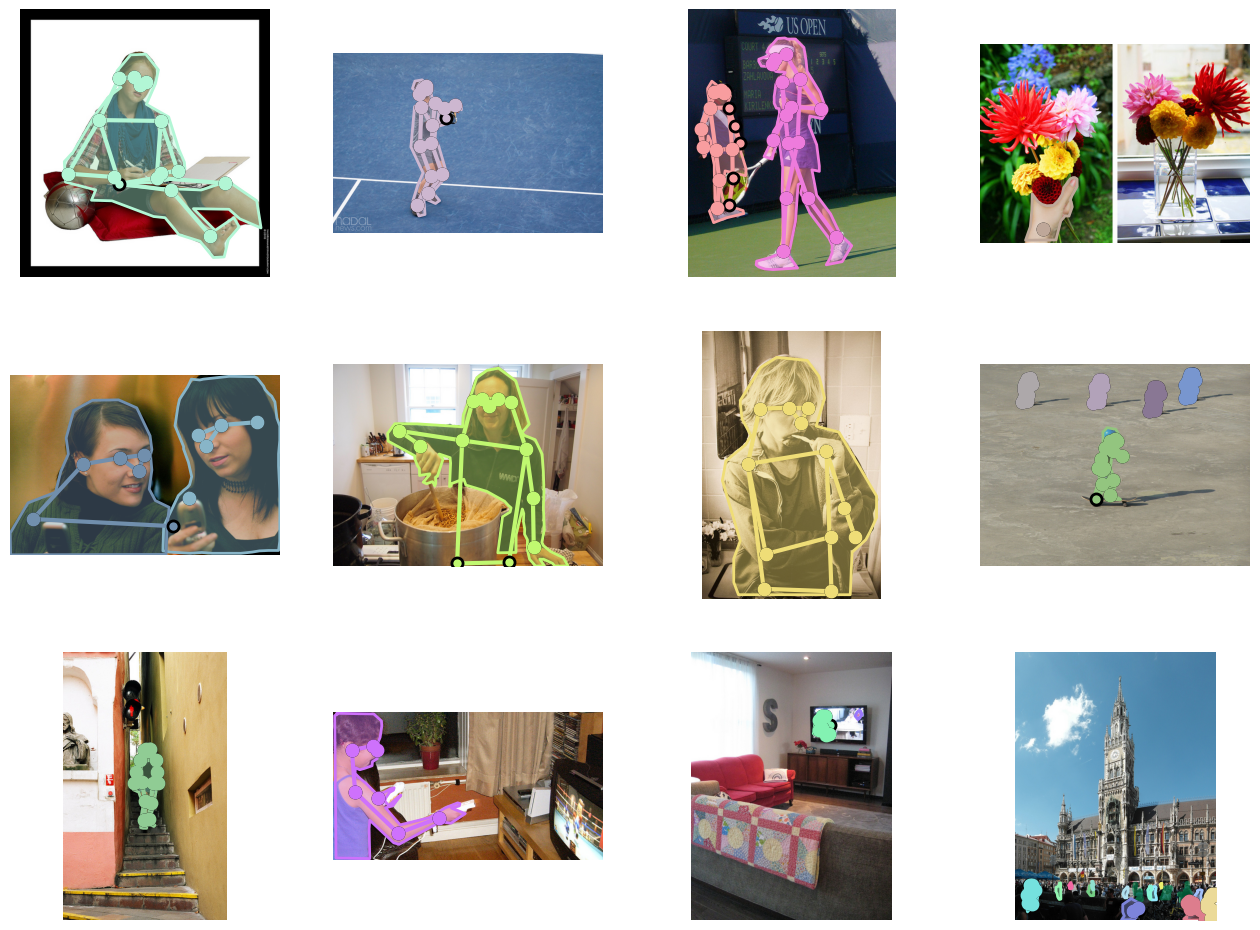

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

In [13]:
#@title Images with captions
annFile = "annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!


A girl sits on a pillow thinking and writing into a notebook.
the student is posing with a notebook and a volleyball.
A young woman working in a notebook while sitting on a cushion.
The child has a ball, notebook, and pen.
a girl sitting on a pillow while doing some homework


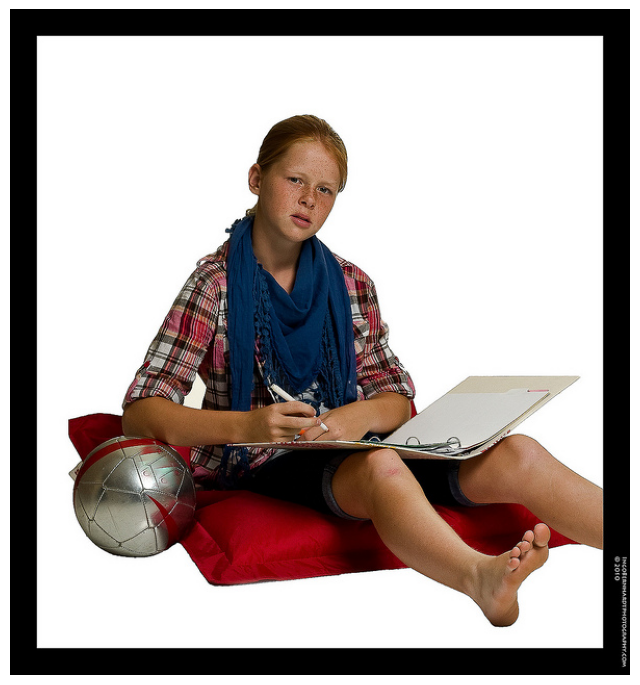

In [ ]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.axis('Off')
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

## Trainig dataset provides examples of people that do not appear in the main front of the image and it does not describe them

A living room filled with furniture and a TV.
a television is hanging on a wall in a room
a room with a screen and a grey couch
A living room with some couches and a quilt 
A room with couches, a letter and a television on the wall and a blanket on the back of one of the couches. 


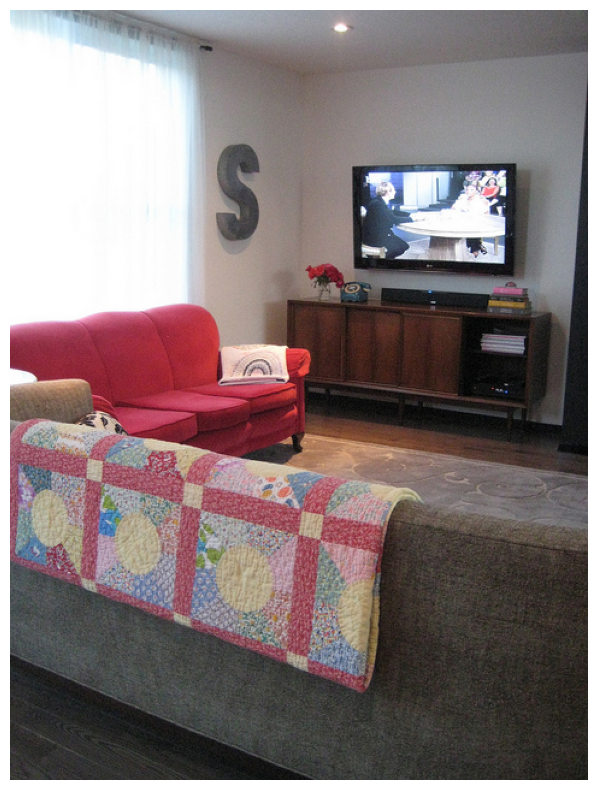

In [ ]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.axis('Off')
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

## Image captioning generator

In [ ]:
coco.loadImgs(next_pix[10])[0]

{'license': 1,
 'file_name': '000000426191.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000426191.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-15 23:00:22',
 'flickr_url': 'http://farm7.staticflickr.com/6018/5956932052_7038916ab3_z.jpg',
 'id': 426191}

In [14]:
#@title Prepare trainig dataset
def preprocess_input(instances,imgIdss,caps):
  '''
    Preprocess file that remove puntuation, chanhes '-' for blank space
    and lowers each word in the caption and finally adds a starting and ending token
    to associate the image with the captions
  '''
  # dictionary that stores and associates images with captions
  dataset = dict()
  # get caption for all images in the training dataset
  for imgid in imgIdss:
      img = instances.loadImgs(imgid)[0]
      annIds = caps.getAnnIds(imgIds=img['id']);
      #list with all caption objects
      anns = caps.loadAnns(annIds)
      imgcaptions = []
 
      for cap in anns:
          
          # Remove punctuation
          cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
          cap = '<start> ' + cap
          # Replace - to blank
          cap = cap.replace("-"," ")

          # Split string into word list and Convert each word into lower case
          '''cap = cap.split()
          cap = [word.lower() for word in cap]'''
          cap = cap.lower()
          
          # join word list in a sentence with <start> and <end> tokens
          # for the encoder
          
          cap = cap + ' <end>'
          imgcaptions.append(cap)
          
      dataset[img['coco_url']] = imgcaptions

  return dataset

In [15]:
dataset = preprocess_input(coco,imgIdss,coco_caps)
training_dataset = preprocess_input(coco,train_imgIds,coco_caps)
validation_dataset = preprocess_input(coco,val_imgIds,coco_caps)

In [16]:
#@title Preprocess and Tokenize captions
from itertools import chain

def tokenize_captions(dataset):
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]
  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_words = len(tokenizer.word_index) + 1
  return total_words,tokenizer

In [17]:
total_words,tokenizer = tokenize_captions(dataset)

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# load the model (excluding the top FC layer)
inception_model = InceptionV3(weights='imagenet',include_top=False, pooling='avg')

87910968/87910968 [==============================] - 3s 0us/step


In [62]:
def feature_extraction(dataset,output_path, batch_size=32):
  # Set the image size
  img_size = (299, 299)
  if os.path.exists(output_path):
    image_features = np.load(output_path, allow_pickle=True).item()
  else:
      image_features = {}
  
  # Loop over batches of images
  num_batches = int(np.ceil(len(dataset) / batch_size))
  for i in tqdm(range(num_batches)):
      batch_keys = list(dataset.keys())[i*batch_size:(i+1)*batch_size]
      batch_images = []
      # Load and preprocess the images in the batch
      for img_key in batch_keys:
          img = io.imread(img_key)
          if img.ndim != 3:
              img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
          img = cv2.resize(img, img_size)
          img = np.expand_dims(img, axis=0)
          img = preprocess_input(img)
          batch_images.append(img)

      # Extract features from the batch of images
      batch_images = np.vstack(batch_images)
      batch_features = inception_model.predict(batch_images)

      # Add the features to the dictionary
      for j, img_key in enumerate(batch_keys):
          image_features[img_key] = batch_features[j]

      # Save the preprocessed features to file after each batch
      np.save(output_path, image_features)
  print("Image features length: ", len(image_features))
  return image_features

In [63]:
training_features_path = 'training_features.npy'
validation_features_path = 'validation_features.npy'

In [ ]:
training_features = feature_extraction(training_dataset,training_features_path)
validation_features = feature_extraction(validation_dataset,validation_features_path)

  0%|          | 0/75 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


In [53]:
training_dataset.keys()

dict_keys(['http://images.cocodataset.org/train2017/000000175418.jpg', 'http://images.cocodataset.org/train2017/000000406866.jpg', 'http://images.cocodataset.org/train2017/000000269103.jpg', 'http://images.cocodataset.org/train2017/000000104416.jpg', 'http://images.cocodataset.org/train2017/000000018441.jpg', 'http://images.cocodataset.org/train2017/000000247394.jpg', 'http://images.cocodataset.org/train2017/000000111830.jpg', 'http://images.cocodataset.org/train2017/000000382607.jpg', 'http://images.cocodataset.org/train2017/000000001408.jpg', 'http://images.cocodataset.org/train2017/000000311776.jpg', 'http://images.cocodataset.org/train2017/000000573388.jpg', 'http://images.cocodataset.org/train2017/000000418379.jpg', 'http://images.cocodataset.org/train2017/000000423209.jpg', 'http://images.cocodataset.org/train2017/000000326182.jpg', 'http://images.cocodataset.org/train2017/000000389103.jpg', 'http://images.cocodataset.org/train2017/000000036528.jpg', 'http://images.cocodataset.or

In [55]:
training_features['http://images.cocodataset.org/train2017/000000069968.jpg']

array([0.05349452, 0.17111388, 0.07369998, ..., 0.        , 0.01677163,
       0.0331561 ], dtype=float32)

In [56]:
training_features['http://images.cocodataset.org/train2017/000000378586.jpg']

KeyError: ignored

In [21]:
#@title Load extracted features in memory
training_features = np.load(training_features_path, allow_pickle=True).item()
validation_features = np.load(validation_features_path, allow_pickle=True).item()

In [59]:
training_dataset['http://images.cocodataset.org/train2017/000000378586.jpg']

['<start> a wing of a jet while waiting for the instructions to leave <end>',
 '<start> a plane wing with a white jet airliner in the background <end>',
 '<start> two planes on the runway in an airport <end>',
 '<start> a white sas jet liner on a run way <end>',
 '<start> a group of airplanes on a runway waiting to take off <end>']

In [23]:
#@title Pad text sequences
def dict_to_list(dataset):
    return [desc for key in dataset.keys() for desc in dataset[key]]

def max_length(dataset):
    return max(len(desc.split()) for desc in dict_to_list(dataset))

    
max_length = max_length(dataset)

In [24]:
def data_generator(dataset, image_features, tokenizer, max_length, batch_size):
    """
    Generates batches of image and caption pairs for training or validation.

    Args:
        dataset: A dictionary containing image URLs and their corresponding captions.
        image_features: A dictionary containing preprocessed image features.
        tokenizer: A Tokenizer object for tokenizing captions.
        max_length: Maximum length of a caption.
        batch_size: Batch size for training or validation.

    Yields:
        A tuple of (batch_image_features, batch_captions), where
        - batch_image_features: A numpy array of preprocessed image features.
        - batch_captions: A numpy array of tokenized captions.
    """
    keys = list(dataset.keys())
    while True:
        np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i+batch_size]
            batch_image_features = []
            batch_captions = []
            for key in batch_keys:
                # Get the preprocessed image features
                image_feature = image_features[key]

                # Get a random caption for the image
                caption_list = dataset[key]
                caption = caption_list[np.random.randint(len(caption_list))]

                # Tokenize the caption and pad or truncate it to max_length
                caption_sequence = tokenizer.texts_to_sequences([caption])[0]
                caption_sequence = pad_sequences([caption_sequence], maxlen=max_length, padding='post', truncating='post')[0]

                # Add the image feature and caption sequence to the batch
                batch_image_features.append(image_feature)
                batch_captions.append(caption_sequence)

            # Convert the batch to numpy arrays
            batch_image_features = np.array(batch_image_features)
            batch_captions = np.array(batch_captions)

            yield batch_image_features, batch_captions

In [34]:
for i in range(3):
    batch_image_features, batch_captions = next(train_generator)
    print("Batch {}: ".format(i+1))
    for j in range(3):
        image_feature = batch_image_features[j]
        caption = batch_captions[j]
        decoded_caption = decode_caption(caption)
        print("\t Image Feature Shape: {}, Caption: {}".format(image_feature.shape, decoded_caption))

KeyError: ignored

In [25]:
#@title Data generators for training and validation set
# Initialize the generator for the training dataset
train_generator = data_generator(training_dataset, training_features, tokenizer, max_length, 32)

# Initialize the generator for the validation dataset
val_generator = data_generator(validation_dataset, validation_features, tokenizer, max_length, 32)

In [50]:
training_dataset.keys() == training_features.keys()

False

In [26]:
#@title Machine translation and recall metrics
class ScoreCallbacks(tf.keras.callbacks.Callback):

    def __init__(self, tokenizer, generator, max_length):
        super(ScoreCallbacks, self).__init__()
        self.tokenizer = tokenizer
        self.generator = generator
        self.max_length = max_length

    def on_epoch_end(self, epoch, logs={}):
        # Generate captions for validation set
        actual, predicted = [], []
        for image_features, target_seq in self.generator:
            # Use model to generate a caption
            caption = self.generate_desc(image_features)

            # Add actual and predicted captions to lists
            actual.append([target.split() for target in target_seq])
            predicted.append(caption.split())

        # Compute BLEU score
        bleu_score = corpus_bleu(actual, predicted)

        # Compute ROUGE score
        rouge = Rouge()
        scores = rouge.get_scores(actual, predicted, avg=True)
        rouge_score = scores['rouge-l']['f']

        # Compute METEOR score
        meteor_score = 0
        for i in range(len(actual)):
            meteor_score += meteor_score(actual[i], predicted[i])
        meteor_score /= len(actual)

        # Log scores
        logs['val_bleu'] = bleu_score
        logs['val_rouge'] = rouge_score
        logs['val_meteor'] = meteor_score

    def generate_desc(self, photo):
        in_text = ''
        for i in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            pred = self.model.predict([photo,sequence], verbose=0)
            pred = np.argmax(pred)
            word = word_for_id(pred, self.tokenizer)

            if word is None:
                break
            in_text += ' ' + word

            if word == 'end':
                break
        return in_text

In [27]:
#@title Baseline model architecture 
from keras.utils import plot_model
class ImageCaptioningModel:
    
    def __init__(self, total_words, max_length):
        self.total_words = total_words
        self.max_length = max_length
        self.strategy = tf.distribute.MirroredStrategy()
        self.num_replicas_in_sync = self.strategy.num_replicas_in_sync
        self.model = self.define_model()
        
    def define_model(self):

        # features from the CNN model squeezed from 2048 to 256 nodes
        with self.strategy.scope():
          inputs1 = Input(shape=(2048,))
          fe1 = Dropout(0.5)(inputs1)
          fe2 = Dense(256, activation=tf.nn.relu)(fe1)

          # LSTM sequence model
          inputs2 = Input(shape=(self.max_length,))
          se1 = Embedding(self.total_words, 256, mask_zero=True)(inputs2)
          se2 = Dropout(0.5)(se1)
          se3 = LSTM(256)(se2)

          # Merging both models
          decoder1 = add([fe2, se3])
          decoder2 = Dense(256, activation=tf.nn.relu)(decoder1)
          outputs = Dense(self.total_words, activation=tf.nn.softmax)(decoder2)

          # tie it together [image, seq] [word]
          model = Model(inputs=[inputs1, inputs2], outputs=outputs)
          model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))

          # summarize model
          print(model.summary())
          plot_model(model, to_file='model.png', show_shapes=True)

          return model
    
    def train(self, data_generator, epochs, steps_per_epoch, validation_data, validation_steps,callbacks):
        history = self.model.fit(data_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                       validation_data=validation_data, validation_steps=validation_steps,callbacks=callbacks)
        return history
    def evaluate(self, generator):
        loss = self.model.evaluate_generator(generator, verbose=1)
        return loss
    def save(self, filepath):
        self.model.save(filepath)
    @classmethod
    def load(cls, filepath, total_words, max_length):
        model = cls(total_words, max_length).define_model()
        model.load_weights(filepath)
        return model

In [ ]:
#@ Model architecture
def attention_model(vocab_size, max_length, hidden_size=256, embedding_size=256):
    # Image feature extractor model
    input_image = Input(shape=(2048,))
    image_features = Dropout(0.5)(input_image)
    image_features = Dense(hidden_size, activation='relu')(image_features)
    
    # Caption sequence model
    input_caption = Input(shape=(max_length,))
    caption_features = Embedding(vocab_size, embedding_size, mask_zero=True)(input_caption)
    caption_features = Dropout(0.5)(caption_features)
    lstm = LSTM(hidden_size, return_sequences=True)(caption_features)
    
    # Attention mechanism
    repeat_image_features = RepeatVector(max_length)(image_features)
    attention_concat = Concatenate(axis=2)([lstm, repeat_image_features])
    attention_dense = TimeDistributed(Dense(hidden_size, activation='tanh'))(attention_concat)
    attention_score = TimeDistributed(Dense(1, activation='softmax'))(attention_dense)
    context_vector = Multiply()([attention_score, image_features])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)
    
    # Concatenate the context vector and LSTM output
    decoder_input = Concatenate(axis=1)([context_vector, lstm])
    decoder_output = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_input)
    
    # Define and compile the model
    model = Model(inputs=[input_image, input_caption], outputs=decoder_output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='attention_model.png', show_shapes=True)

    return model

In [ ]:
#@title Early stoping
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [30]:
validation_steps = len(validation_dataset) // 32
steps_per_epoch = len(training_dataset) // 32
epochs = 10
# train our model


model = ImageCaptioningModel(total_words, max_length)
print('Number of devices: {}'.format(model.num_replicas_in_sync))


score_callbacks = ScoreCallbacks(tokenizer, val_generator, max_length)


history = model.train(data_generator, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_generator,
                      validation_steps=validation_steps, callbacks=score_callbacks)
loss = model.evaluate(val_generator)
print(loss)

model.save('model.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 37, 256)      935936      ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

ValueError: ignored

1/1 [==============================] - 3s 3s/step





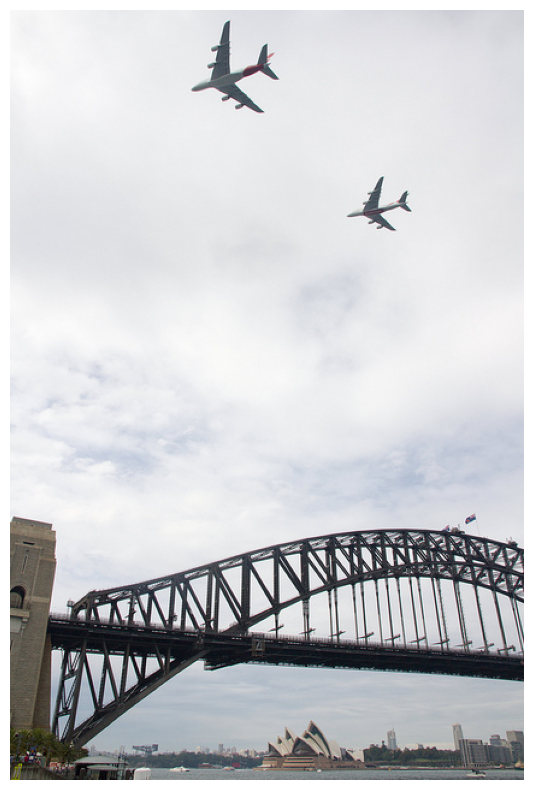

In [33]:
#@title Model testing
#from transformers import BertTokenizer
img_paths = ["000000001761.jpg"]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = ''
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

#model = load_model(...)
photo = extract_features(img_paths[0], inception_model)
img = Image.open(img_paths[0])
#description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
# Add a text description to the image
#print(description)
plt.imshow(img)
plt.axis('Off')
# Show the image with the description
plt.show()